<a href="https://colab.research.google.com/github/AsmaaQ25/GenAI-CMP637-2025/blob/main/Notebooks/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CMP637-GenAI Assignment-phase1 ## DR. Yahia
# Asmaa Qandeel Ali - 202211150
##### November 2025

In [1]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import wandb

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Define utility functions

In [2]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  #first unflatten the tensor
  x = x.view(x.shape[0], 1, 28, 28)
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

## Load and visualize the dataset

In [3]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
  transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])

# This will load the dataset into the folder "datasets" the first time it is run
dataset = torchvision.datasets.MNIST(root="datasets", download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 34.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.73MB/s]


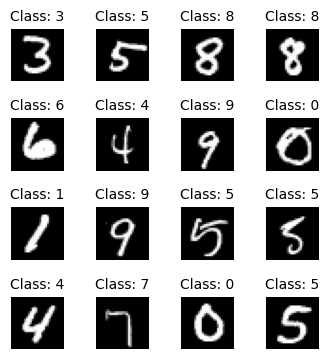

In [4]:
def show_dataset_sample(sample_size: int = 100):
  # sample_size must be a square number so the grid is all full
  loader = DataLoader(dataset, batch_size=sample_size, shuffle=True)
  x, y = next(iter(loader))
  x = x.view(sample_size, 1, 28, 28)
  y = y.view(sample_size)
  show_images(x, y)

show_dataset_sample(sample_size=16)

In [68]:
loader = DataLoader(dataset, batch_size=2, shuffle=True)
x, y = next(iter(loader))

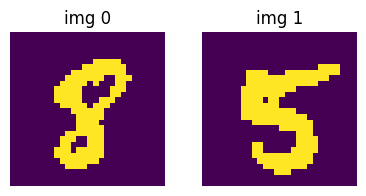

In [69]:
import matplotlib.pyplot as plt
import torch

def show_batch_heatmaps(x, num=8):
    """
    x: a batch tensor either [B,784] or [B,1,28,28]
    num: number of images to display
    """
    x = x[:num]
    x = (x > 0.5).float()
    # reshape if flattened
    if x.dim() == 2 and x.size(1) == 784:
        x = x.view(-1, 28, 28)
    elif x.dim() == 4:
        x = x.squeeze(1)
    else:
        raise ValueError("Input shape must be [B,784] or [B,1,28,28]")

    num = min(num, x.size(0))

    fig, axs = plt.subplots(1, num, figsize=(num*2, 2))

    for i in range(num):
        axs[i].imshow(x[i].cpu().numpy(), cmap='viridis')  # heatmap
        axs[i].axis('off')
        axs[i].set_title(f"img {i}")

    plt.tight_layout()
    plt.show()


# Example usage with a dataloader:
# ------------------------------------------------
# x, y = next(iter(dataloader))
show_batch_heatmaps(x)


In [72]:
x = (x > 0.5).float()
x.unique()

tensor([0., 1.])

In [6]:
x.shape, y.shape, y

(torch.Size([2, 784]), torch.Size([2]), tensor([5, 2]))

In [7]:
y.view(-1,1).shape

torch.Size([2, 1])

In [8]:
x.view(2, 1, 28, 28).shape

torch.Size([2, 1, 28, 28])

In [9]:
# x.view(x[0].size(0), -1)

## Select a device

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cuda


## Define the model

In [11]:
# TODO: Define your model(s) and loss function(s) here.
# You can add as many cells as you like.
# You can add utility functions related to the model here too.

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConditionalMADE(nn.Module):
    def __init__(
        self,
        input_size=784,
        cond_size=10,
        hidden_sizes=[500, 500],
        natural_ordering=True,
        device=None,
    ):
        super().__init__()
        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_sizes = hidden_sizes
        self.n_hidden = len(hidden_sizes)

        # Degrees
        if natural_ordering:
            self.input_degrees = torch.arange(1, input_size + 1)
        else:
            self.input_degrees = torch.randperm(input_size) + 1

        self.hidden_degrees = []
        for h in hidden_sizes:
            # sample degrees in {1, ..., input_size-1}
            self.hidden_degrees.append(torch.randint(1, input_size, (h,)))

        self.output_degrees = torch.arange(1, input_size + 1)

        # Layers: first layer consumes (input + cond)
        layers = []
        layer_input_size = input_size + cond_size
        for h in hidden_sizes:
            layers.append(nn.Linear(layer_input_size, h))
            layer_input_size = h
        layers.append(nn.Linear(layer_input_size, input_size))
        self.layers = nn.ModuleList(layers)

        # Build masks (and register as buffers so they move with .to())
        masks = self.build_masks()   # list of tensors: shapes (in, out)
        # store transposed masks to match layer.weight shape (out, in)
        for i, mask in enumerate(masks):
            self.register_buffer(f"mask_{i}", mask.t())  # mask.t() shape == layer.weight.shape

        # optional: move degrees to buffers for completeness (not strictly necessary)
        self.register_buffer("input_degrees_buf", self.input_degrees)
        self.register_buffer("output_degrees_buf", self.output_degrees)
        # hidden degrees can be saved as list tensors
        for i, hd in enumerate(self.hidden_degrees):
            self.register_buffer(f"hidden_deg_{i}", hd)

        # device if provided
        if device is not None:
            self.to(device)

    def build_masks(self):
        masks = []
        # degrees_prev corresponds to concatenated [cond zeros, input_degrees]
        degrees_prev = torch.cat([torch.zeros(self.cond_size), self.input_degrees]).long()

        for h_degrees in self.hidden_degrees:
            # mask shape: (in_features, out_features)
            mask = (degrees_prev[:, None] <= h_degrees[None, :]).float()
            masks.append(mask)
            degrees_prev = h_degrees

        # output mask: degrees_prev (last hidden) -> outputs (strictly less)
        mask_out = (degrees_prev[:, None] < self.output_degrees[None, :]).float()
        masks.append(mask_out)
        return masks

    def forward(self, x, y_cond):
        # ensure inputs are float and devices match
        x = x.float()
        y_cond = y_cond.float()
        h = torch.cat([x, y_cond], dim=-1)

        for i, layer in enumerate(self.layers):
            mask = getattr(self, f"mask_{i}")  # shape == (out, in) because we registered transposed
            # layer.weight shape is (out, in)
            W_masked = layer.weight * mask  # elementwise
            h = F.linear(h, W_masked, layer.bias)
            if i != len(self.layers) - 1:
                h = F.relu(h)
        return h

    @torch.no_grad()
    def sample(self, y_cond, device='cpu'):
        batch = y_cond.size(0)
        x = torch.zeros(batch, self.input_size, device=device)
        for i in range(self.input_size):
            logits = self.forward(x, y_cond.to(next(self.parameters()).device))
            probs = torch.sigmoid(logits[:, i])
            x[:, i] = torch.bernoulli(probs)
        return x

    def debug_masks(self):
        # prints simple summaries
        for i in range(len(self.layers)):
            mask = getattr(self, f"mask_{i}")
            print(f"mask_{i} shape {mask.shape} sum {mask.sum().item():.0f}")


## Instantiate models and optimizers

## Train the model

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_made(name, model, dataloader, max_patience, epochs=10, lr=1e-3, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # NLL for Bernoulli output
    wandb.watch(model, log="all")

    nll_his = []
    epoch_losses = []
    best_nll = 1000.
    patience = 0
    
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}"):
            x = x.to(device)
            x = (x > 0.5).float()
            y_cond =  nn.functional.one_hot(y, num_classes=10).float().to(device)
            optimizer.zero_grad()
            logits = model(x, y_cond)
            loss = criterion(logits, x)  # NLL
            # right after logits = model(x, y_cond)
            # print("devices:",
            #       "logits", logits.device,
            #       "x", x.device,
            #       "y_cond", y_cond.device)
            
            # with torch.no_grad():
            #     print("logits stats: min {:.3f}, max {:.3f}, mean {:.3f}".format(
            #         logits.min().item(), logits.max().item(), logits.mean().item()))
            #     probs = torch.sigmoid(logits)
            #     print("probs stats: min {:.3f}, max {:.3f}, mean {:.4f}".format(
            #         probs.min().item(), probs.max().item(), probs.mean().item()))
            #     # fraction of pixels predicted ~1
            #     print("frac ones (p>0.5):", (probs>0.5).float().mean().item())

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
        wandb.log({"epoch": epoch + 1, "loss": loss.item()})
        nll_his.append(loss.item())
        if epoch == 0:
            print('saved!')
            torch.save(model.state_dict(), f"{name}.pth")
            best_nll = loss
        else:
            if loss < best_nll:
                print('saved!')
                best_nll = loss
                patience = 0
                torch.save(model.state_dict(), f"{name}.pth")
            else:
                patience = patience + 1

        if patience > max_patience:
            break
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch}: NLL loss = {epoch_loss:.4f}")
        wandb.log({"epoch": epoch + 1, "epoch_loss": epoch_loss })

    return nll_his, epoch_loss

In [53]:
# TODO: Define the hyperparameters here.
input_dim = 28*28
hidden_layers = 2
hidden_dim = [1000,1000]
actv = "relu"
grad_clip = 5.0
n_mixtures = 10
lr = 1e-5

# Instantiate the model and optimizer here
model = ConditionalMADE(input_size=input_dim,
                        cond_size=10,
                        hidden_sizes=hidden_dim,
                        natural_ordering=True, device = device)
model.debug_masks()
optimizer = optim.Adam(model.parameters(), lr=lr)

mask_0 shape torch.Size([1000, 794]) sum 389402
mask_1 shape torch.Size([1000, 1000]) sum 529688
mask_2 shape torch.Size([784, 1000]) sum 382122


In [52]:
def mask_summaries(model):
    for name, buf in model.named_buffers():
        if name.startswith("mask_"):
            print(name, buf.shape, "nonzero:", (buf!=0).sum().item())
mask_summaries(model)


mask_0 torch.Size([5000, 794]) nonzero: 2031622
mask_1 torch.Size([5000, 5000]) nonzero: 12595557
mask_2 torch.Size([784, 5000]) nonzero: 1925906


In [45]:
x0 = torch.zeros(2, 784, device=device)   # zeros input
y0 = torch.zeros(2, 10, device=device)    # zeros or some one-hot
logits = model(x0, y0)
print("initial logits mean", logits.mean().item(), "min", logits.min().item(), "max", logits.max().item())


initial logits mean -1.7369089619023725e-05 min -0.018344655632972717 max 0.020191043615341187


In [59]:
# usage
# training parameters
epochs = 3
batch_size = 64
max_patience = 40


train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
wandb.login(key="9bf31a65f3249f4d45183b47993a4fdc3328db1f")
wandb_logger = wandb.init(project="GenAI-Assignment-phase1", name="made_2*1k-4epoch",
                         config = {
                        "learning_rate": lr,
                        "batch_size": batch_size,
                        "optimizer": "adam",
                        "epochs": epochs,
                        "model_architecture": "MADE",
                         "hidden_layers": hidden_dim }) 
loss_history, l2 = train_made("made_mnist-v4", model, train_loader, 
                          max_patience, epochs=epochs, lr=lr, device=device)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/3: 100%|██████████| 938/938 [00:08<00:00, 105.40it/s]


saved!
Epoch 1: NLL loss = 0.0209


Epoch 2/3: 100%|██████████| 938/938 [00:09<00:00, 102.85it/s]


Epoch 2: NLL loss = 0.0204


Epoch 3/3: 100%|██████████| 938/938 [00:08<00:00, 104.34it/s]

Epoch 3: NLL loss = 0.0202


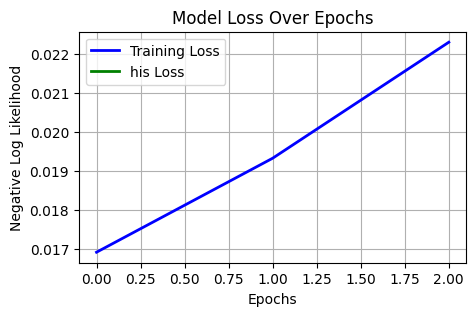

In [60]:
plt.figure(figsize=(5, 3))
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)
plt.plot(l2, label='his Loss', color='green', linewidth=2)

plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.grid(True)
plt.show()

## [Optional] Save and/or load the model

In [56]:
## Optional TODO: Save the model if you want to store your work on disk and load it later
torch.save(model.state_dict(), "made_2*512_25e.pth")
# input_dim = 28*28
# hidden_layers = 2
# hidden_dim = [1000,1000]
# loaded_model = ConditionalMADE(input_size=input_dim,
#                         cond_size=10,
#                         hidden_sizes=hidden_dim,
#                         natural_ordering=True)
# loaded_model.load_state_dict(torch.load("made_mnist.pth"))

## Write the generation function

## Generate some images and display them

In [64]:
y_zeros = torch.zeros(100, model.cond_size, device=device)
logits = model(x, y_zeros)
logits

tensor([[ -2.0837,  -2.0777,  -2.1212,  ..., -19.9655, -19.5204, -19.8783],
        [ -2.0837,  -2.0777,  -2.1212,  ..., -19.9655, -19.5204, -19.8783],
        [ -2.0837,  -2.0777,  -2.1212,  ..., -20.0588, -19.6264, -20.0082],
        ...,
        [ -2.0837,  -2.0777,  -2.1212,  ..., -20.7675, -20.5490, -20.9932],
        [ -2.0837,  -2.0777,  -2.1212,  ..., -21.1402, -20.7299, -20.7778],
        [ -2.0837,  -2.0777,  -2.1212,  ..., -19.8888, -19.5646, -19.9216]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

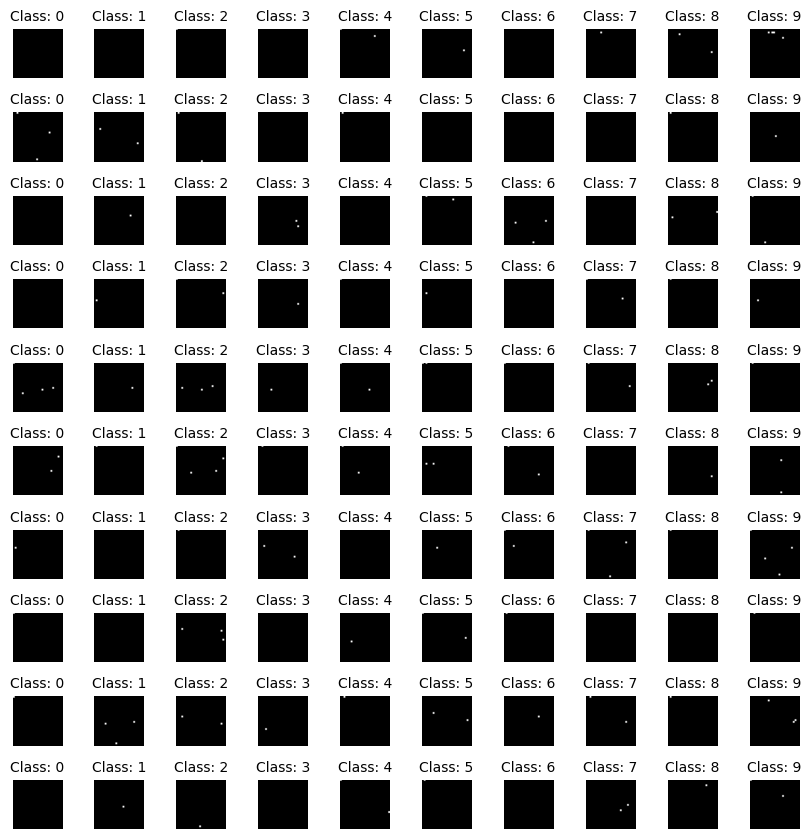

In [61]:
def generate(y: torch.Tensor) -> torch.Tensor:
    y_cond =  nn.functional.one_hot(y, num_classes=10).float().to(device)
    model.eval()
    new_x = model.sample(y_cond, device = device)
    return new_x
    
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)

x = generate(y)
show_images(x, y)

In [58]:
# log images in wandb
x = x.view(x.shape[0], 1, 28, 28)
if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
    
batch_size = x.shape[0]
# Draw a grid or images
wandb_image_list = []
sample_table = wandb.Table(columns=["images", "labels"])
for i in range(batch_size):
    caption_text = f"Label: {y[i].item()}"
    wandb_image = wandb.Image(x[i], caption=caption_text)
    wandb_image_list.append(wandb_image)
# 4. Log the entire list in a single wandb.log() call
wandb.log({"Generated Samples Grid": wandb_image_list})
wandb_logger.finish()

epoch,▁▁▅▅██
epoch_loss,█▂▁
loss,█▃▁
epoch,4
epoch_loss,0.0294
loss,0.02392


## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).